**Mengoneksikan BigQuery Ke Colab**

In [179]:
# Meng-install dan import library BigQuery
!pip install --upgrade google-cloud-bigquery

# Login ke akun Google
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

project_id = "retail-churn-project"

# Membuat client BigQuery
client = bigquery.Client(project=project_id)

# Menulis query
query = """
select
  Customer_ID,
  Product,
  date(timestamp_seconds(cast(First_Transaction / 1000 as int64))) as First_Transaction_Date,
  date(timestamp_seconds(cast(Last_Transaction / 1000 as int64))) as Last_Transaction_Date,
  Average_Transaction_Amount,
  Count_Transaction,

--Menambah kolom 'Total_Amount'
  Average_Transaction_Amount * Count_Transaction as Total_Amount,

--Menambah kolom 'is_churn': True jika Last_Transaction sebelum 1 Agustus 2018
case
  when date(timestamp_seconds(cast(Last_Transaction / 1000 as int64))) < date('2018-08-01') then true
  else false
end as is_churn
from `retail_dataset.data_retail`;
"""
# Mengeksekusi query ke dalam dataframe
df = client.query(query).to_dataframe()

# Mengecek 5 data teratas
df.head()

,Customer_ID,Product,First_Transaction_Date,Last_Transaction_Date,Average_Transaction_Amount,Count_Transaction,Total_Amount,is_churn
0,350761,Baju,2018-12-24,2018-12-24,1575580,1,1575580,False
1,25436,Baju,2018-06-07,2018-06-07,1027351,1,1027351,True
2,53474,Baju,2018-06-03,2018-06-03,908294,1,908294,True
3,124590,Baju,2018-11-25,2018-11-25,890890,1,890890,False
4,43830,Baju,2018-07-11,2018-07-11,2817561,1,2817561,True


**Mengonversi Data Ke Dalam Bentuk CSV**

In [180]:
# Menyimpan ke file CSV
df.to_csv('df.csv', index=False)

# Mengecek tipe data dan missing values
df.info()

# Statistik deskriptif numerik
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Customer_ID                 100000 non-null  Int64  
 1   Product                     100000 non-null  object 
 2   First_Transaction_Date      100000 non-null  dbdate 
 3   Last_Transaction_Date       100000 non-null  dbdate 
 4   Average_Transaction_Amount  100000 non-null  Int64  
 5   Count_Transaction           100000 non-null  Int64  
 6   Total_Amount                100000 non-null  Int64  
 7   is_churn                    100000 non-null  boolean
dtypes: Int64(4), boolean(1), dbdate(2), object(1)
memory usage: 5.9+ MB


,Customer_ID,Average_Transaction_Amount,Count_Transaction,Total_Amount
count,100000.0,100000.0,100000.0,100000.0
mean,193083.99694,1373157.358,11.6985,16404237.30386
std,200747.292955,1544434.671051,35.417324,62896260.950393
min,654.0,0.0,1.0,0.0
25%,60994.5,478303.75,1.0,718321.75
50%,121441.0,905937.0,2.0,1852243.0
75%,196023.0,1636371.5,6.0,8506847.5
max,846213.0,48810144.0,3852.0,7780489164.0


**The Outlier of Average Transaction Amount, Count Transaction, and Total Amount**

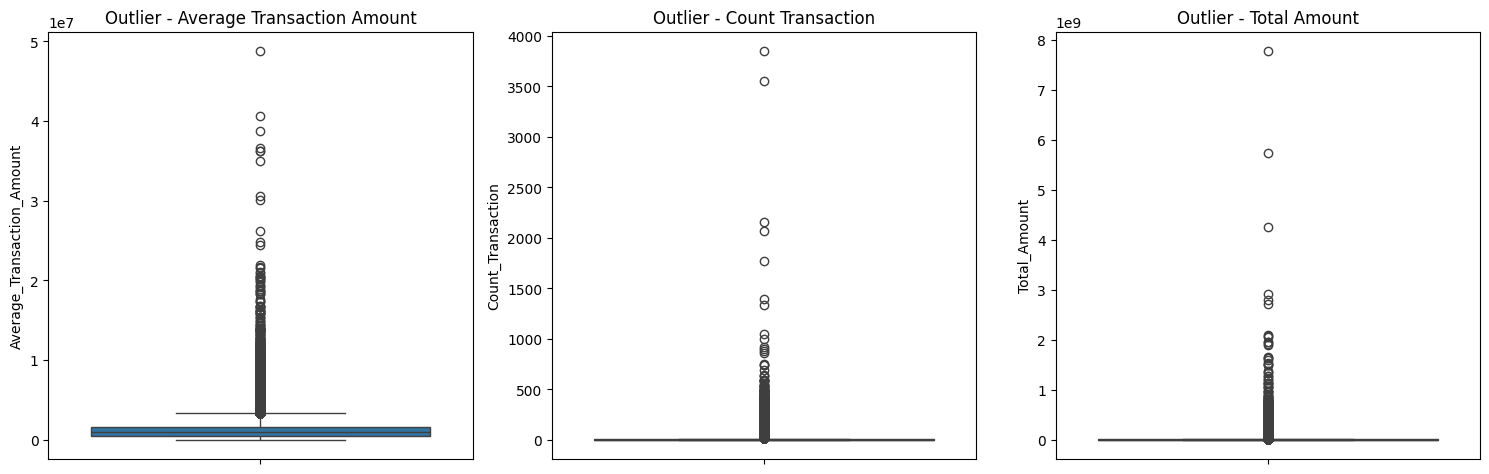

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# Boxplot Average_Transaction_Amount
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Average_Transaction_Amount'])
plt.title('Outlier - Average Transaction Amount')

# Boxplot Count_Transaction
plt.subplot(1, 3, 2)
sns.boxplot(y=df['Count_Transaction'])
plt.title('Outlier - Count Transaction')

# Boxplot Total_Amount
plt.subplot(1, 3, 3)
sns.boxplot(y=df['Total_Amount'])
plt.title('Outlier - Total Amount')

plt.tight_layout()
plt.show()


**Menghitung Jumlah Pelanggan Churn dan Tidak Churn (Calculating the Number of Churned and Retained Customers)**

In [182]:
is_churn=df['is_churn'].value_counts()
print(is_churn)

is_churn
True     66569
False    33431
Name: count, dtype: Int64


**Proporsi Jumlah Pelanggan Churn dan Tidak Churn (Proportion of Churned and Retained Customers)**

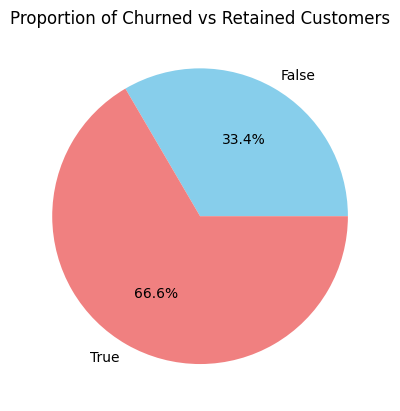

In [183]:
import matplotlib.pyplot as plt

df['is_churn'].value_counts().sort_index().plot(kind='pie', labels=['False', 'True'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Churned vs Retained Customers')
plt.ylabel('')
plt.show()

**Proporsi Churned Customer untuk Setiap Produk (Proportion of Churn by Product)**

<Figure size 640x480 with 0 Axes>

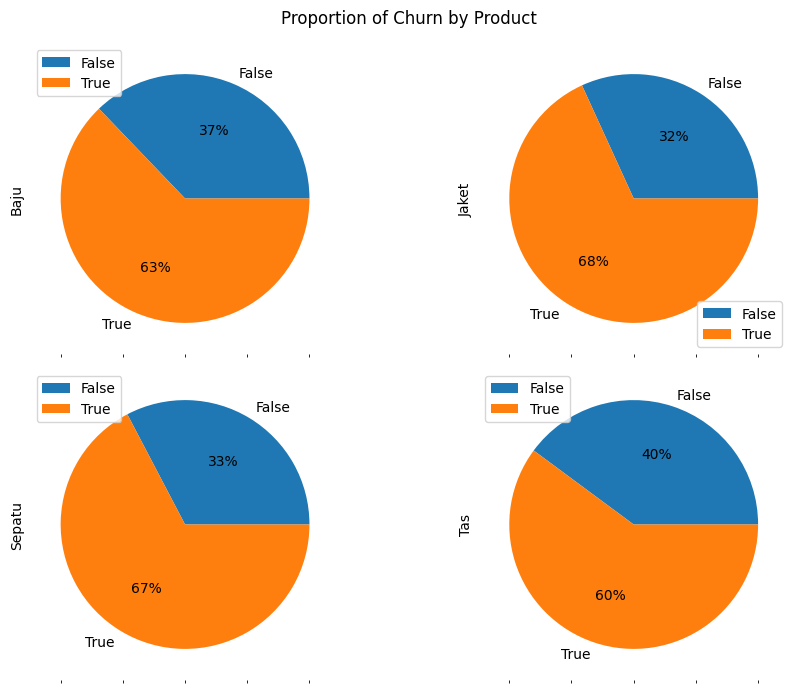

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
# Melakukan pivot data dengan pivot_table
df_piv = df.pivot_table(index='is_churn',
                        columns='Product',
                        values='Customer_ID',
                        aggfunc='count',
                        fill_value=0)

# Mendapatkan Proportion Churn by Product
plot_product = df_piv.count().sort_values(ascending=False).head(5).index

# Mengeplot Pie Chart
df_piv = df_piv.reindex(columns=plot_product)
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion of Churn by Product')
plt.tight_layout()
plt.show()

**Perolehan Pelanggan Baru Tiap Tahun (Customer Acquisition by Year)**

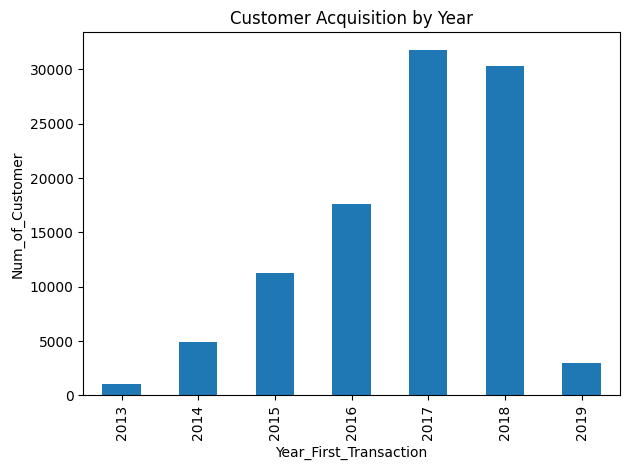

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Membuat plot Customer Acquisition by Year
df_year = df.groupby('Year_First_Transaction')['Customer_ID'].count()

df_year.plot(
    x='Year_First_Transaction',
    y='Customer_ID',
    kind='bar',
    title='Customer Acquisition by Year'
)

plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

**Tren Tahunan Total Amount (Trend of Total Amount by Year)**

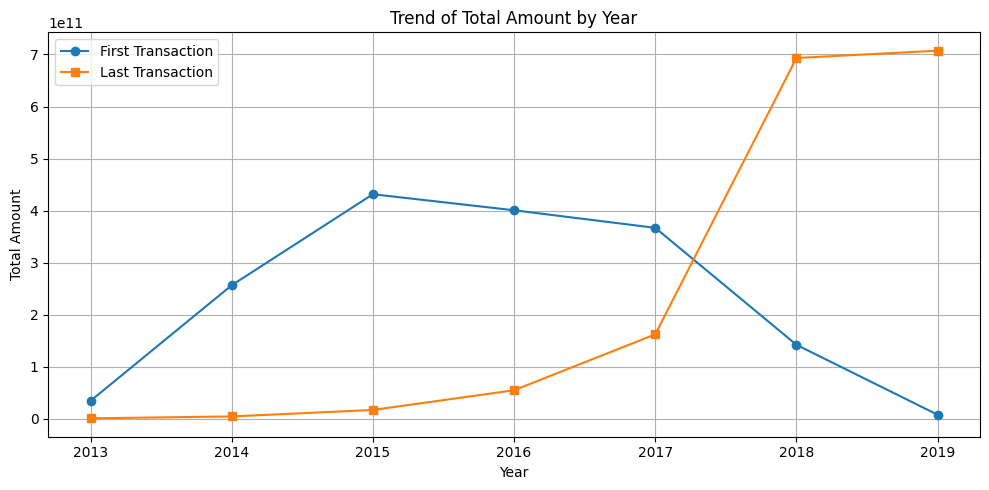

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Menghitung Total Amount tiap tahun
total_by_first = df.groupby('Year_First_Transaction')['Total_Amount'].sum().reset_index()
total_by_last = df.groupby('Year_Last_Transaction')['Total_Amount'].sum().reset_index()

# Membuat Plot Diagram
plt.figure(figsize=(10,5))
plt.plot(total_by_first['Year_First_Transaction'], total_by_first['Total_Amount'], marker='o', label='First Transaction')
plt.plot(total_by_last['Year_Last_Transaction'], total_by_last['Total_Amount'], marker='s', label='Last Transaction')
plt.title('Trend of Total Amount by Year')
plt.xlabel('Year')
plt.ylabel('Total Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Distribusi Kategorisasi Count Transaction (Customer Distribution by Count Transaction Group)**

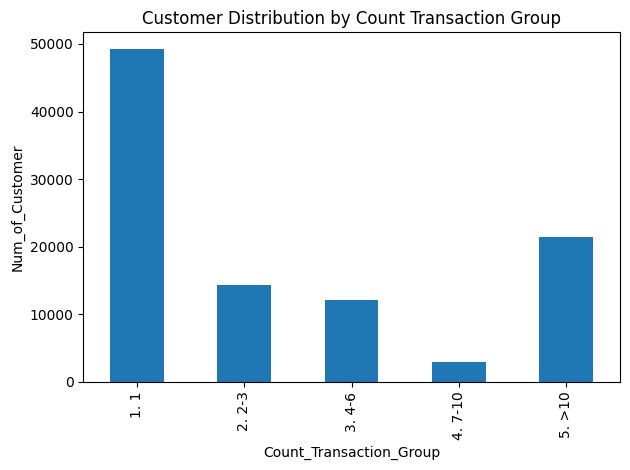

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

plt.clf()
# Kategorisasi jumlah transaksi
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1. 1'

    elif (row['Count_Transaction'] >1 and row['Count_Transaction']<= 3):
        val ='2. 2-3'

    elif (row['Count_Transaction']> 3 and row['Count_Transaction']<=6):
        val ='3. 4-6'

    elif (row['Count_Transaction']>6 and row['Count_Transaction']<=10):
        val ='4. 7-10'
    else:
        val ='5. >10'
    return val

# Tambahkan kolom baru
df['Count_Transaction_Group'] = df.apply(func, axis=1)

df_year = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()

df_year.plot(x='Count_Transaction_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaction Group')
plt.xlabel('Count_Transaction_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()


**Distribusi Kategorisasi Average Transaction Amount (Customer Distribution by Average Transaction Amount Group)**

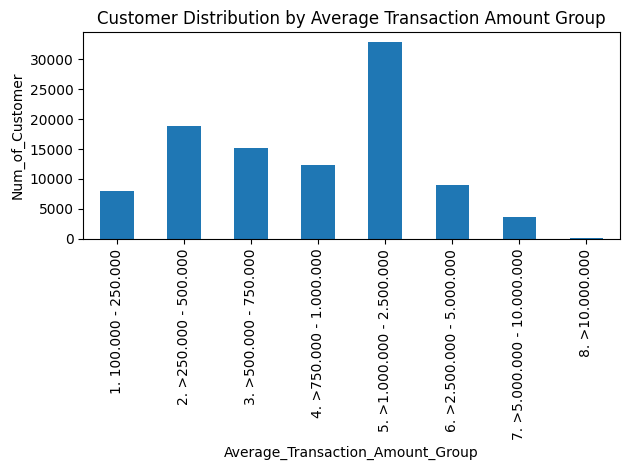

In [188]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

plt.clf()
# Kategorisasi rata-rata besar transaksi
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <= 250000):
        val = '1. 100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <= 500000):
        val = '2. >250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 750000):
        val = '3. >500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <= 1000000):
        val = '4. >750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val = '5. >1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val = '6. >2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val = '7. >5.000.000 - 10.000.000'
    else:
        val = '8. >10.000.000'
    return val

# Tambahkan kolom baru
df['Average_Transaction_Amount_Group'] = df.apply(f, axis=1)

df_year = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()

df_year.plot(x='Average_Transaction_Amount_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Average Transaction Amount Group')
plt.xlabel('Average_Transaction_Amount_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()